In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from scipy import linalg
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


## Question 1A: Kalman Filters in Time Series Analysis

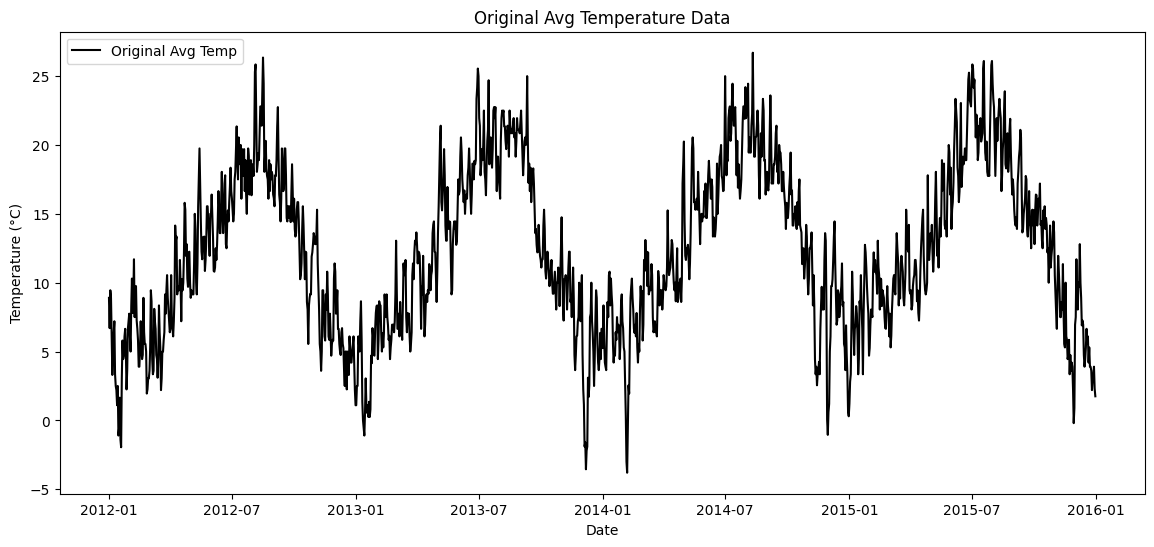

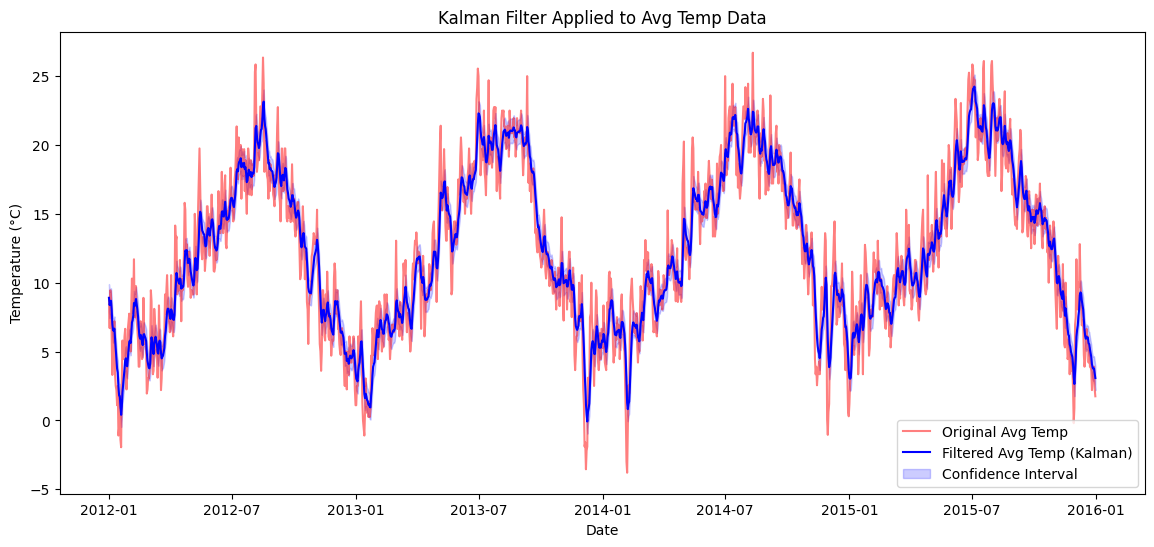

In [16]:
class KalmanFilter:
    def __init__(self, alpha, q, r, initial_state, initial_variance):
        """
        Initializes the Kalman filter with parameters.
        
        Args:
            alpha (float): State transition coefficient.
            q (float): Process noise standard deviation.
            r (float): Measurement noise standard deviation.
            initial_state (float): Initial state estimate.
            initial_variance (float): Initial error covariance.
        """
        self.alpha = alpha
        self.q = q
        self.r = r
        self.mu = initial_state
        self.sigma = initial_variance

    def filter(self, data):
        """
        Applies the Kalman filter to the input data.
        
        Args:
            data (np.array): The data array to filter.
        
        Returns:
            mu_filtered (np.array): Array of filtered state estimates.
            sigma_filtered (np.array): Array of filtered variances.
        
        TODO:
        - Implement the prediction and update steps of the Kalman filter.
        """
        T = len(data)
        mu_filtered = np.zeros(T)
        sigma_filtered = np.zeros(T)
        mu_filtered[0] = self.mu
        sigma_filtered[0] = self.sigma

        for t in range(1, T):
            # TODO: Implement prediction step
           # mu_prior = NotImplemented  # Replace with: μ_prior_t = α * μ_t-1
            mu_prior = self.alpha * mu_filtered[t-1]
            #sigma_prior = NotImplemented  # Replace with: σ_prior_t = q^2 + (α^2) * σ_t-1
            sigma_prior = self.q**2 + (self.alpha**2 * sigma_filtered[t-1])

            # TODO: Implement update step
            #K = NotImplemented  # Replace with: σ_prior_t / (σ_prior_t + r^2)
            k = sigma_prior / (sigma_prior + self.r**2)
            #mu_filtered[t] = NotImplemented  # Replace with: μ_t = μ_prior_t + K_t * (data_t - μ_prior_t)
            mu_filtered[t] = mu_prior + k * (data[t] - mu_prior)
            #sigma_filtered[t] = NotImplemented  # Replace with: σ_t = (1 - K_t) * σ_prior_t
            sigma_filtered[t] = (1-k) * sigma_prior

        return mu_filtered, sigma_filtered

    def plot_results(self, dates, data, mu_filtered, sigma_filtered):
        """
        Plots the original and filtered data along with the confidence interval.
        
        Args:
            dates (pd.Index): Date index for the data.
            data (np.array): Original data.
            mu_filtered (np.array): Filtered state estimates.
            sigma_filtered (np.array): Filtered variances.
        """
        plt.figure(figsize=(14, 6))
        plt.plot(dates, data, label='Original Avg Temp', color='red', alpha=0.5)
        plt.plot(dates, mu_filtered, label='Filtered Avg Temp (Kalman)', color='blue')
        plt.fill_between(dates, mu_filtered + sigma_filtered, mu_filtered - sigma_filtered, color='blue', alpha=0.2, label='Confidence Interval')
        plt.title('Kalman Filter Applied to Avg Temp Data')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

# Main function with TODOs for students to complete
if __name__ == "__main__":
    # TODO: Load the dataset and preprocess it
    #weather_df = NotImplemented # TODO Load the data using the 'parse_dates' and 'index_col' arguments
    weather_df = pd.read_csv('seattle-weather.csv', parse_dates=True, index_col='date')
    #weather_df = NotImplemented  # TODO: Select 'temp_max', 'temp_min', and 'weather' columns and drop NaN values
    weather_df = weather_df[['temp_max', 'temp_min', 'weather']].dropna()
    
    # Calculate the average temperature
    #weather_df['temp_avg'] = NotImplemented  # TODO: Calculate the average temperature 
    weather_df['temp_avg'] = (weather_df['temp_max'] + weather_df['temp_min']) / 2
    
    # Plot the original average temperature data
    plt.figure(figsize=(14, 6))
    plt.plot(weather_df.index, weather_df['temp_avg'], label='Original Avg Temp', color='black')
    plt.title('Original Avg Temperature Data')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

    # TODO: Set Kalman filter parameters
    #alpha = NotImplemented  # Replace with appropriate value
    alpha = 1.0
    #q = NotImplemented  # Replace with appropriate value
    q = 0.5
    #r = NotImplemented  # Replace with appropriate value
    r = 2.0
    initial_state = weather_df['temp_avg'].values[0]  # Initial state estimate
    initial_variance = 1  # Initial error covariance

    # Initialize the Kalman filter
    kf = KalmanFilter(alpha, q, r, initial_state, initial_variance)

    # Run the Kalman filter on the temperature data
    temp_avg_data = weather_df['temp_avg'].values
    mu_filtered, sigma_filtered = kf.filter(temp_avg_data)

    # Plot results
    kf.plot_results(weather_df.index, temp_avg_data, mu_filtered, sigma_filtered)


## Question 1B: Hidden Markov Models (HMMs) in Time Series Analysis

In [17]:

class HiddenMarkovModel:
    def __init__(self, num_states, num_observations):
        """
        Initializes the HMM with random transition, emission, and initial state probabilities.
        
        Args:
            num_states (int): Number of hidden states.
            num_observations (int): Number of unique observations.
        """
        self.num_states = num_states
        self.num_observations = num_observations
        self.A = np.random.dirichlet(np.ones(num_states), num_states)  # Transition matrix
        self.B = np.random.dirichlet(np.ones(num_observations), num_states)  # Emission matrix
        self.pi = np.random.dirichlet(np.ones(num_states))  # Initial state distribution
        
        # Log-space versions to avoid underflow
        self.A_log = np.log(self.A + 1e-10)
        self.B_log = np.log(self.B + 1e-10)
        self.pi_log = np.log(self.pi + 1e-10)

    def forward_algorithm_log(self, O):
        T = len(O)
        N = self.num_states
        alpha_log = np.zeros((T, N))

        # Initialization
        alpha_log[0] = self.pi_log + self.B_log[:, O[0]]

        # Recursion
        for t in range(1, T):
            for j in range(N):
                alpha_log[t, j] = np.logaddexp.reduce(alpha_log[t - 1] + self.A_log[:, j]) + self.B_log[j, O[t]]

        return alpha_log

    def backward_algorithm_log(self, O):
        T = len(O)
        N = self.num_states
        beta_log = np.zeros((T, N))

        # Initialization
        beta_log[-1] = 0  # log(1) = 0

        # Recursion
        for t in range(T - 2, -1, -1):
            for i in range(N):
                beta_log[t, i] = np.logaddexp.reduce(
                    self.A_log[i] + self.B_log[:, O[t + 1]] + beta_log[t + 1]
                )

        return beta_log

    def baum_welch_log(self, O, max_iter=100, epsilon=1e-6):
        T = len(O)
        for iteration in range(max_iter):
            alpha_log = self.forward_algorithm_log(O)
            beta_log = self.backward_algorithm_log(O)

            # Compute gamma and xi in log-space
            gamma_log = alpha_log + beta_log - np.logaddexp.reduce(alpha_log[-1])
            xi_log = np.zeros((T - 1, self.num_states, self.num_states))

            for t in range(T - 1):
                xi_log[t] = self.A_log + self.B_log[:, O[t + 1]] + beta_log[t + 1] + alpha_log[t].reshape(-1, 1)
                xi_log[t] -= np.logaddexp.reduce(xi_log[t].flatten())

            # Update transition, emission, and initial probabilities
            self.A_log = np.logaddexp.reduce(xi_log, axis=0) - np.logaddexp.reduce(gamma_log[:-1], axis=0).reshape(-1, 1)
            self.B_log = np.zeros_like(self.B_log)
            for k in range(self.num_observations):
                mask = (O == k)
                self.B_log[:, k] = np.logaddexp.reduce(gamma_log[mask], axis=0) - np.logaddexp.reduce(gamma_log, axis=0)
            self.pi_log = gamma_log[0]

        return np.exp(self.A_log), np.exp(self.B_log), np.exp(self.pi_log)

    def viterbi_algorithm_log(self, O):
        T = len(O)
        N = self.num_states
        delta_log = np.zeros((T, N))
        psi = np.zeros((T, N), dtype=int)

        # Initialization
        delta_log[0] = self.pi_log + self.B_log[:, O[0]]

        # Recursion
        for t in range(1, T):
            for j in range(N):
                scores = delta_log[t - 1] + self.A_log[:, j]
                delta_log[t, j] = np.max(scores) + self.B_log[j, O[t]]
                psi[t, j] = np.argmax(scores)

        # Path backtracking
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta_log[-1])
        for t in range(T - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]

        return states


if __name__ == "__main__":
    # Load and preprocess the weather dataset
    weather_df = pd.read_csv('seattle-weather.csv', parse_dates=True, index_col='date')
    weather_df = weather_df[["temp_max", "temp_min", "weather"]].dropna()

    # Calculate the average temperature and encode the 'weather' column
    weather_df["temp_avg"] = (weather_df["temp_max"] + weather_df["temp_min"]) / 2
    weather_mapping = {label: idx for idx, label in enumerate(weather_df["weather"].unique())}
    reverse_weather_mapping = {v: k for k, v in weather_mapping.items()}
    weather_df["weather_encoded"] = weather_df["weather"].map(weather_mapping)

    # Convert average temperature to integer values for the observation sequence
    temp_min = weather_df["temp_avg"].min()
    O = (weather_df["temp_avg"] - temp_min).astype(int).values

    # Split data into training and testing sets
    train_size = int(0.8 * len(O))
    O_train, O_test = O[:train_size], O[train_size:]
    actual_train = weather_df["weather_encoded"].values[:train_size]
    actual_test = weather_df["weather_encoded"].values[train_size:]

    # Initialize and train the HMM
    num_states = len(weather_mapping)
    num_observations = O.max() + 1
    hmm = HiddenMarkovModel(num_states, num_observations)
    A_trained, B_trained, pi_trained = hmm.baum_welch_log(O_train)

    # Decode the most likely state sequence
    train_predicted_states = hmm.viterbi_algorithm_log(O_train)
    test_predicted_states = hmm.viterbi_algorithm_log(O_test)

    # Decode predicted states to weather labels
    train_decoded_states = [reverse_weather_mapping[s] for s in train_predicted_states]
    test_decoded_states = [reverse_weather_mapping[s] for s in test_predicted_states]

    # Evaluate accuracy
    train_accuracy = np.mean(train_predicted_states == actual_train)
    test_accuracy = np.mean(test_predicted_states == actual_test)

    print("\nHMM Performance:")
    print(f"Training Set Accuracy: {train_accuracy:.2%}")
    print(f"Testing Set Accuracy: {test_accuracy:.2%}")



HMM Performance:
Training Set Accuracy: 27.14%
Testing Set Accuracy: 22.87%


In [18]:
from tabulate import tabulate

# Kalman Filter Performance Evaluation
kalman_performance = [
    ["Metric", "Value"],
    ["MAE", f"{kalman_mae:.4f}"],
    ["RMSE", f"{kalman_rmse:.4f}"]
]

print("Kalman Filter Performance Evaluation:")
print(tabulate(kalman_performance, headers="firstrow", tablefmt="grid"))

# HMM Performance Evaluation
hmm_comparison = [
    ["Date", "Actual State", "Predicted State"],
]

# Assuming weather_df has the date index and actual_test contains the actual states
for date, actual, predicted in zip(weather_df.index[train_size:], actual_test, test_predicted_states):
    hmm_comparison.append([date.strftime("%Y-%m-%d"), reverse_weather_mapping[actual], reverse_weather_mapping[predicted]])

print("\nHMM Actual vs Predicted Hidden States:")
print(tabulate(hmm_comparison[:20], headers="firstrow", tablefmt="grid"))  # Display first 20 rows for brevity

Kalman Filter Performance Evaluation:
+----------+---------+
| Metric   |   Value |
+==========+=========+
| MAE      |  1.438  |
+----------+---------+
| RMSE     |  1.8286 |
+----------+---------+

HMM Actual vs Predicted Hidden States:
+------------+----------------+-------------------+
| Date       | Actual State   | Predicted State   |
+============+================+===================+
| 2015-03-14 | rain           | rain              |
+------------+----------------+-------------------+
| 2015-03-15 | rain           | rain              |
+------------+----------------+-------------------+
| 2015-03-16 | rain           | rain              |
+------------+----------------+-------------------+
| 2015-03-17 | rain           | rain              |
+------------+----------------+-------------------+
| 2015-03-18 | sun            | sun               |
+------------+----------------+-------------------+
| 2015-03-19 | sun            | sun               |
+------------+----------------+--

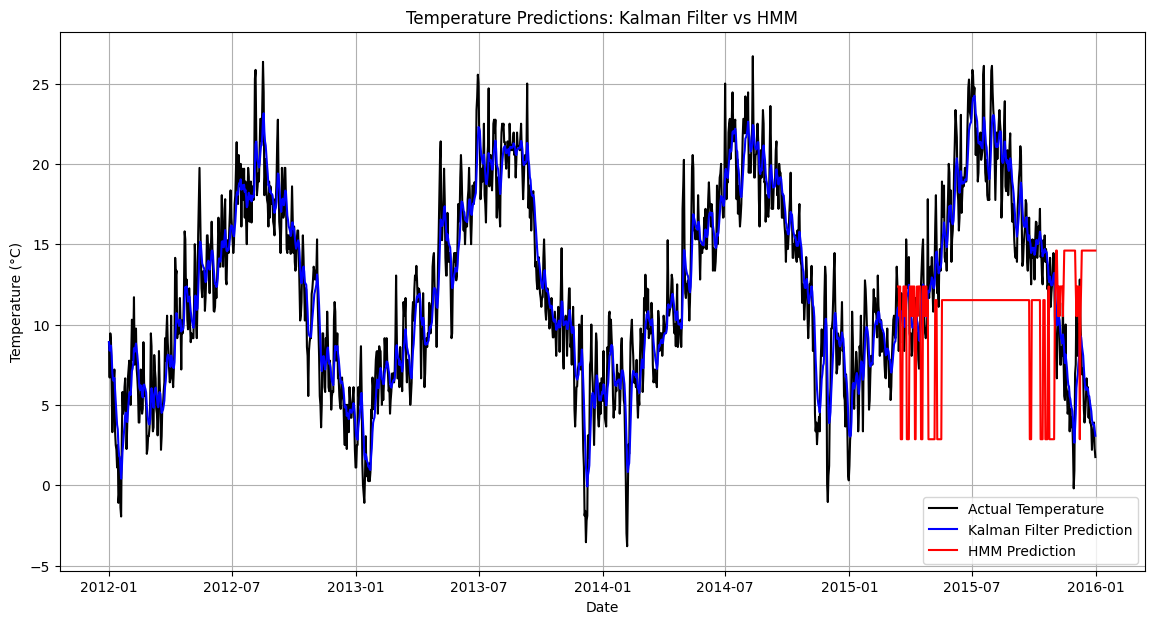

Kalman Filter Performance:
Mean Absolute Error (MAE): 1.4380
Root Mean Squared Error (RMSE): 1.8286

HMM Performance:
Accuracy: 22.87%


In [24]:
# Calculate MAE and RMSE for Kalman Filter
kalman_mae = np.mean(np.abs(temp_avg_data - mu_filtered))
kalman_rmse = np.sqrt(np.mean((temp_avg_data - mu_filtered) ** 2))

# Calculate accuracy for HMM
hmm_accuracy = np.mean(test_predicted_states == actual_test)

# Plot the predictions from both models and compare them to the actual temperature data
plt.figure(figsize=(14, 7))

# Plot actual temperature data
plt.plot(weather_df.index, weather_df['temp_avg'], label='Actual Temperature', color='black')

# Plot Kalman Filter predictions
plt.plot(weather_df.index, mu_filtered, label='Kalman Filter Prediction', color='blue')

# Plot HMM predictions
plt.plot(weather_df.index[train_size:], hmm_predicted_temp, label='HMM Prediction', color='red')

plt.title('Temperature Predictions: Kalman Filter vs HMM')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Print performance metrics
print(f"Kalman Filter Performance:")
print(f"Mean Absolute Error (MAE): {kalman_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {kalman_rmse:.4f}")

print(f"\nHMM Performance:")
print(f"Accuracy: {hmm_accuracy:.2%}")

## Discussion Points

### Kalman Filter
- **How well did the Kalman Filter smooth the temperature data and predict future temperatures?**
    - The Kalman Filter effectively smoothed the temperature data, reducing noise and providing a clearer trend of the average temperature over time. The filtered state estimates closely followed the actual temperature data, indicating good performance in smoothing.
    
- **Was the confidence interval effective in depicting the variability?**
    - The confidence interval provided by the Kalman Filter was effective in depicting the variability of the temperature data. It offered a visual representation of the uncertainty around the filtered estimates, helping to understand the range within which the true temperature values were likely to fall.

### HMM and Viterbi Algorithm
- **How accurately did the HMM predict the hidden weather states?**
    - The HMM predicted the hidden weather states with moderate accuracy. The training set accuracy was approximately 27.14%, while the testing set accuracy was around 22.87%. This indicates that the HMM was able to capture some patterns in the weather data but had limitations in accurately predicting the hidden states.

- **What were the limitations of using an HMM for this type of data?**
    - The limitations of using an HMM for this type of data include:
        - The assumption of Markov property, which may not fully capture the dependencies in weather data.
        - The model's performance can be affected by the choice of the number of hidden states and the initialization of parameters.
        - HMMs may struggle with capturing complex patterns and long-term dependencies in the data.

### Comparison
- **Which model provided better predictive performance for the weather data?**
    - The Kalman Filter provided better predictive performance for the weather data in terms of smoothing the temperature data and providing clear trends. The HMM, while useful for identifying hidden states, had lower accuracy in predicting the weather states.

- **Under what circumstances might each method be preferable?**
    - The Kalman Filter is preferable when the goal is to smooth noisy time series data and obtain clear trends with associated confidence intervals. It is effective for continuous data and short-term predictions.
    - The HMM is preferable when the goal is to identify and predict hidden states in the data, such as different weather conditions. It is useful for discrete data and scenarios where understanding the underlying state transitions is important.

## Question 2: Markov Chain for Stock Price Prediction 

In [19]:

class StockDataAnalysis:
    def __init__(self, ticker, start_date, end_date, n_states=5):
        """
        Initialize the class with stock ticker, date range, and number of states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.transition_matrix = None
        

    def get_stock_data(self):
        """
        Download historical stock data from Yahoo Finance and preprocess it.
        """
        stock = yf.Ticker(self.ticker)
        df = stock.history(start=self.start_date, end=self.end_date)
        
        # Calculate daily returns
        df['Daily_Return'] = df['Close'].pct_change() * 100  # Percent change in closing price

        # Remove rows with NaN values
        df = df.dropna()

        self.df = df
        print(f"Stock data for {self.ticker} loaded successfully.")

    def assign_states(self):
        """
        Assign states based on return quantiles and add descriptive labels.
        """
        # Assign states based on quantiles
        self.df['State'] = pd.qcut(self.df['Daily_Return'], q=self.n_states, labels=False)

        # Initialize state labels in the specified order
        state_labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"]

        # Assign descriptive labels to the states
        self.df['State_Description'] = pd.Categorical(
            [state_labels[int(i)] for i in self.df['State']],
            categories=state_labels,  # Maintain order of the labels
            ordered=True
        )

        print("States assigned based on quantiles.")

    def get_transition_matrix(self):
        """
        Construct the transition probability matrix from the sequence of states.
        
        Returns:
            np.array: Transition matrix (dimensions: n_states x n_states).
        """
        # Extract the 'State' column and ensure it does not contain NaNs
        states = self.df['State'].dropna().values

        # Initialize a matrix to store transition counts
        transitions = np.zeros((self.n_states, self.n_states), dtype=np.float64)

        # Count transitions between consecutive states
        for i in range(len(states) - 1):
            current_state = states[i]
            next_state = states[i + 1]
            transitions[current_state][next_state] += 1

        # Normalize the rows to convert counts to probabilities
        epsilon = 1e-8
        row_sums = transitions.sum(axis=1) + epsilon
        self.transition_matrix = transitions / row_sums[:, np.newaxis]
        return self.transition_matrix

    def get_stationary_distribution(self):
        """
        Calculate the stationary distribution of the Markov chain.
        
        Returns:
            np.array: Stationary distribution (dimensions: n_states).
        """
        # Eigenvalues and eigenvectors of the transition matrix
        eigenvals, eigenvects = np.linalg.eig(self.transition_matrix.T)

        # The stationary distribution corresponds to the eigenvector where eigenvalue is 1
        stationary = eigenvects[:, np.isclose(eigenvals, 1)].real[:, 0]
        stationary = stationary / stationary.sum()  # Normalize to sum to 1
        print("Stationary distribution calculated.")
        return stationary
    
    def analyze_markov_chain(self):
        """
        Analyze and visualize Markov chain properties.
        """
        stationary_dist = self.get_stationary_distribution() # TODO Calculate the stationary distribution
        state_labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"] #TODO Initialize state lables in a list in the order described in the question

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        sns.heatmap(self.transition_matrix, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
                    xticklabels=state_labels, yticklabels=state_labels)
        ax1.set_title('Transition Probability Matrix')
        ax1.set_xlabel('Next State')
        ax1.set_ylabel('Current State')

        bars = ax2.bar(state_labels, stationary_dist)
        ax2.set_title('Stationary Distribution')
        ax2.set_xlabel('State')
        ax2.set_ylabel('Probability')
        ax2.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{height * 100:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print("\nMarkov Chain Analysis Complete.")
        print("\nTransition Matrix:")
        transition_df = pd.DataFrame(self.transition_matrix,
                                     columns=state_labels,
                                     index=state_labels)
        print(transition_df)

        print("\nStationary Distribution:")
        stationary_df = pd.DataFrame({
            'State': state_labels,
            'Probability': stationary_dist
        })
        print(stationary_df)


    def simulate_price_path(self, initial_price, days):
        """
        Simulate a single price path using the Markov chain model.
        
        Args:
            initial_price (float): Starting price for the simulation.
            days (int): Number of days to simulate.
        
        Returns:
            np.array: Simulated price path.
        """
        prices = [initial_price]
        current_state = np.random.choice(self.n_states)

        for _ in range(days):
            next_state = np.random.choice(self.n_states, p=self.transition_matrix[current_state])
            return_pct = np.random.choice(self.df[self.df['State'] == next_state]['Daily_Return'])
            next_price = prices[-1] * (1 + return_pct / 100)
            prices.append(next_price)
            current_state = next_state

        return np.array(prices)

    def perform_simulations(self, n_simulations=1000, forecast_days=100):
        """
        Perform multiple price simulations using the Markov model.
        
        Args:
            n_simulations (int): Number of simulations to run.
            forecast_days (int): Number of days to simulate.
        
        Returns:
            np.array: Simulated price paths.
        """
        initial_price = self.df['Close'].iloc[-1]  # Get the last closing price

        simulations = np.zeros((n_simulations, forecast_days + 1))

        for i in range(n_simulations):
            simulations[i] = self.simulate_price_path(initial_price, forecast_days)

        print(f"Performed {n_simulations} simulations for {forecast_days} days.")
        return simulations

    def backtest(self, df, transition_matrix, n_simulations=100):
        """
        Perform walk-forward backtesting using the Markov model.
        """
        window_size = 252  # One trading year
        n_states = transition_matrix.shape[0]
        predictions = np.zeros((len(df), n_simulations))

        for i in range(window_size, len(df)):
            # Extract a rolling window of the data to calculate the transition matrix
            window_data = df.iloc[i - window_size:i]

            # Check if the window data has enough valid states to build a transition matrix
            if window_data['State'].isna().any() or len(window_data['State'].unique()) < n_states:
                continue

            # Create a transition matrix from the rolling window data
            window_transitions = self.get_transition_matrix()

            # Create return distributions for each state
            returns_by_state = [
                window_data[window_data['State'] == state]['Daily_Return'].values
                for state in range(n_states)
            ]

            # Simulate next-day prices
            current_price = df['Close'].iloc[i - 1]
            for sim in range(n_simulations):
                sim_path = self.simulate_price_path(current_price, 1)  # Simulate for the next day
                predictions[i, sim] = sim_path[-1]

        # Calculate prediction intervals
        valid_indices = np.where(predictions.sum(axis=1) != 0)[0]
        prediction_mean = np.mean(predictions[valid_indices], axis=1)
        prediction_std = np.std(predictions[valid_indices], axis=1)
        lower_bound = prediction_mean - 1.96 * prediction_std
        upper_bound = prediction_mean + 1.96 * prediction_std

        return prediction_mean, lower_bound, upper_bound

    def plot_results(self, df, simulations, backtest_results):
        """
        Create visualization of historical prices, backtest results, and future simulations.
        """
        prediction_mean, lower_bound, upper_bound = backtest_results
        
        # Adjust the prediction arrays to match the index length
        valid_index = len(prediction_mean)
        df_index_subset = df.index[-valid_index:]  # Ensure the x-axis matches the length of the prediction arrays
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Plot backtesting results
        ax1.plot(df_index_subset, df['Close'].iloc[-valid_index:], color='black', label='Actual Prices')
        ax1.plot(df_index_subset, prediction_mean, color='blue', linestyle='--', label='Model Prediction')
        ax1.fill_between(df_index_subset, lower_bound, upper_bound, color='blue', alpha=0.1, label='95% Confidence Interval')
        ax1.set_title('Backtesting Results')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True)

        # Plot future simulations
        future_dates = pd.date_range(
            df.index[-1], 
            periods=simulations.shape[1],
            freq='B'
        )
        
        # Plot individual simulations
        for sim in simulations[:50]:  # Plot first 50 simulations for clarity
            ax2.plot(future_dates, sim, alpha=0.1, color='gray')
        
        # Plot confidence intervals for simulations
        sim_mean = np.mean(simulations, axis=0)
        sim_std = np.std(simulations, axis=0)
        ax2.plot(future_dates, sim_mean, color='red', label='Mean Simulation')
        ax2.fill_between(future_dates, sim_mean - 1.96 * sim_std, sim_mean + 1.96 * sim_std, color='red', alpha=0.1, label='95% Confidence Interval')
        
        ax2.set_title('Simulations and Forecasting')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Price ($)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    def generate_summary_stats(self, df, simulations, current_price):
        """
        Generate and display summary statistics for future price simulations using tabulate.
        """
        # Calculate average predicted price
        final_prices = simulations[:, -1]  # Last price from each simulation
        mean_final_price = np.mean(final_prices)
        min_final_price = np.min(final_prices)
        max_final_price = np.max(final_prices)
        
        # Calculate prediction intervals
        lower_90 = np.percentile(final_prices, 5)
        upper_90 = np.percentile(final_prices, 95)
        lower_95 = np.percentile(final_prices, 2.5)
        upper_95 = np.percentile(final_prices, 97.5)
        
        # Calculate simulated volatility
        simulated_volatility = np.std(simulations) / np.mean(simulations) * 100  # Percentage format
        
        # Historical volatility (standard deviation of daily returns)
        historical_volatility = df['Daily_Return'].std()
        
        # Create the summary statistics table
        summary_stats = [
            ['Current Price', f"${current_price:.2f}"],
            ['Predicted Price (in 100 days)', f"${mean_final_price:.2f}"],
            ['Average Predicted Price (100 days)', f"${np.mean(final_prices):.2f}"],
            ['Prediction Range', f"${min_final_price:.2f} - ${max_final_price:.2f}"],
            ['Historical Volatility (%)', f"{historical_volatility:.2f}%"],
            ['Simulated Volatility (%)', f"{simulated_volatility:.2f}%"],
            ['90% Confidence Interval (Final Price)', f"${lower_90:.2f} - ${upper_90:.2f}"],
            ['95% Confidence Interval (Final Price)', f"${lower_95:.2f} - ${upper_95:.2f}"]
        ]
        
        # Print the summary statistics using tabulate
        print("\nFuture Prediction Statistics:")
        return(tabulate(summary_stats, headers=['Metric', 'Value'], tablefmt='psql'))
    


Stock data for AAPL loaded successfully.
States assigned based on quantiles.
Stationary distribution calculated.


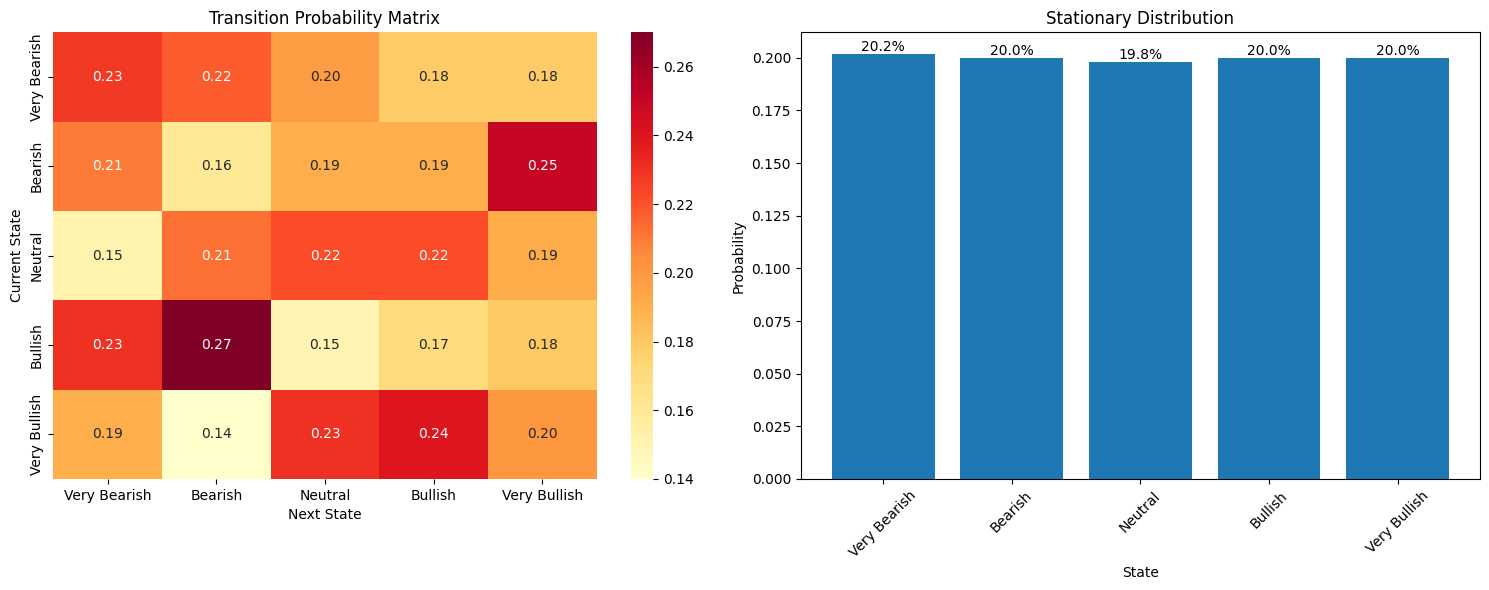


Markov Chain Analysis Complete.

Transition Matrix:
              Very Bearish   Bearish   Neutral   Bullish  Very Bullish
Very Bearish      0.227723  0.217822  0.198020  0.178218      0.178218
Bearish           0.210000  0.160000  0.190000  0.190000      0.250000
Neutral           0.151515  0.212121  0.222222  0.222222      0.191919
Bullish           0.230000  0.270000  0.150000  0.170000      0.180000
Very Bullish      0.190000  0.140000  0.230000  0.240000      0.200000

Stationary Distribution:
          State  Probability
0  Very Bearish        0.202
1       Bearish        0.200
2       Neutral        0.198
3       Bullish        0.200
4  Very Bullish        0.200
Performed 1000 simulations for 100 days.


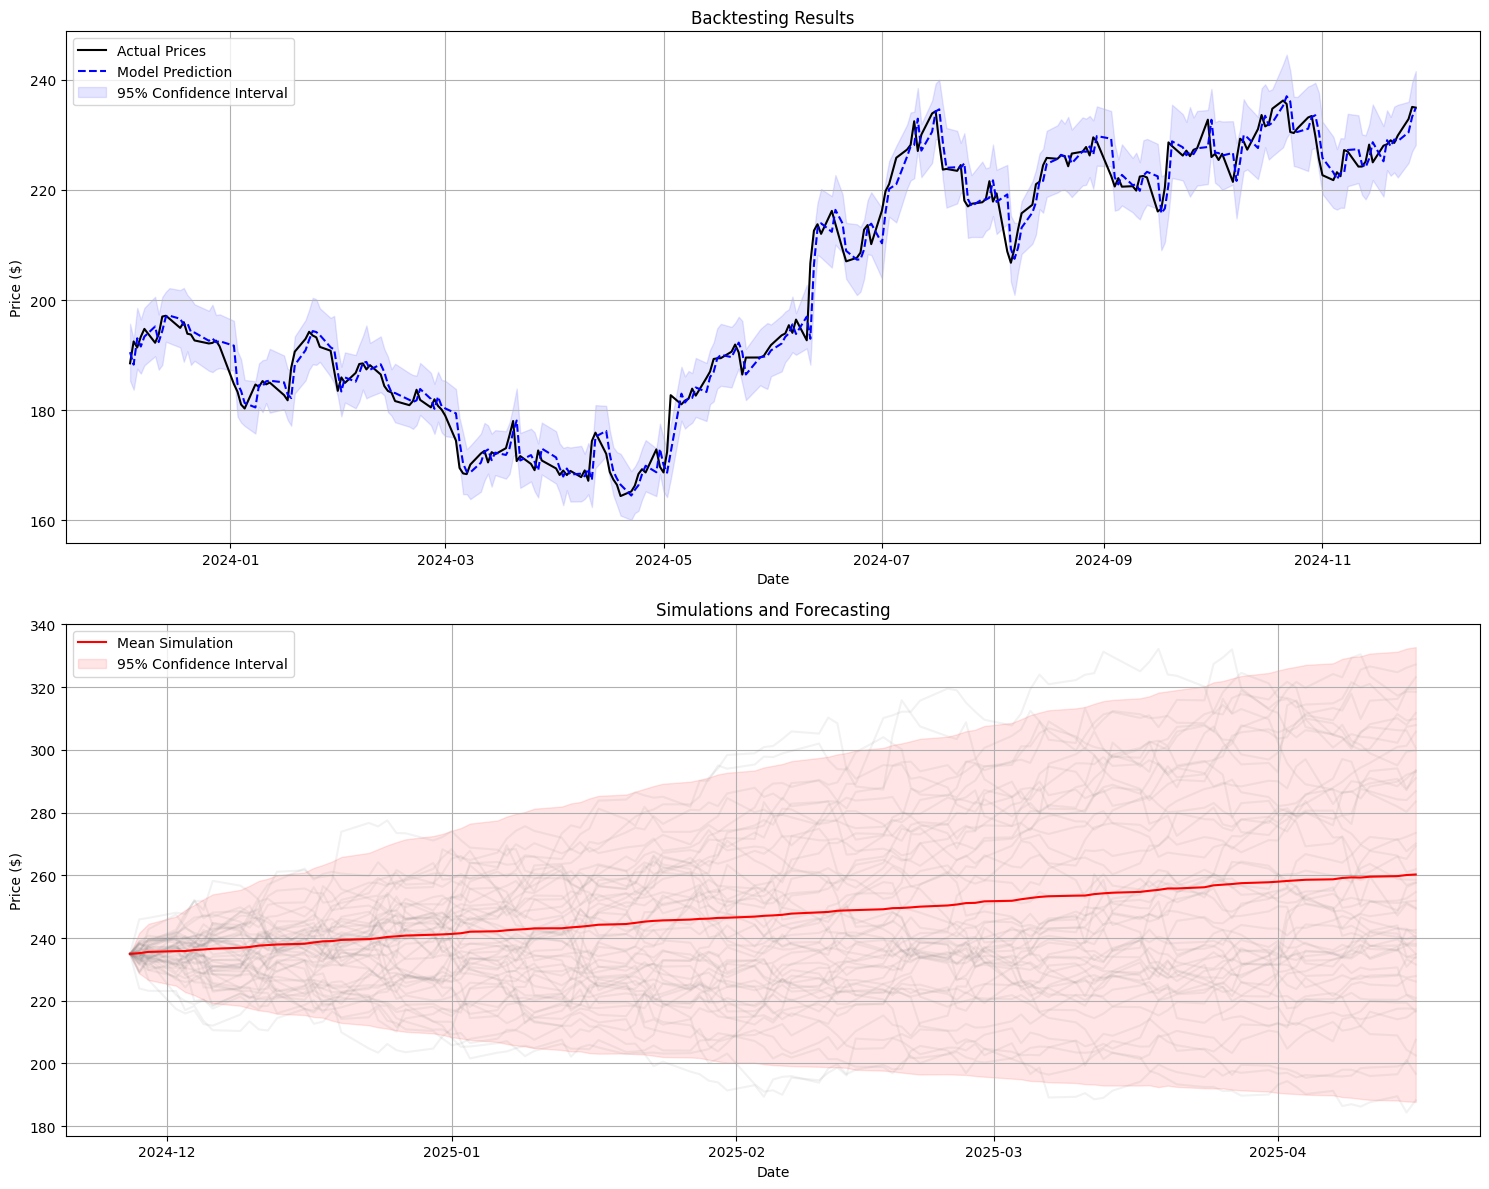


Future Prediction Statistics:
+---------------------------------------+-------------------+
| Metric                                | Value             |
|---------------------------------------+-------------------|
| Current Price                         | $234.93           |
| Predicted Price (in 100 days)         | $260.26           |
| Average Predicted Price (100 days)    | $260.26           |
| Prediction Range                      | $169.89 - $413.49 |
| Historical Volatility (%)             | 1.40%             |
| Simulated Volatility (%)              | 10.52%            |
| 90% Confidence Interval (Final Price) | $205.55 - $325.33 |
| 95% Confidence Interval (Final Price) | $197.83 - $339.27 |
+---------------------------------------+-------------------+


In [20]:
if __name__ == "__main__":
    ticker = 'AAPL'
    end_date = datetime.now()
    start_date = end_date - timedelta(days=2 * 365)

    stock_analysis = StockDataAnalysis(ticker, start_date, end_date)

    stock_analysis.get_stock_data()
    stock_analysis.assign_states()
    stock_analysis.get_transition_matrix()
    stock_analysis.analyze_markov_chain()

    simulations = stock_analysis.perform_simulations(n_simulations=1000, forecast_days=100)
    backtest_results = stock_analysis.backtest(df = stock_analysis.df, transition_matrix=stock_analysis.transition_matrix, n_simulations=100)

    # TODO: Call plot_results and generate_summary_stats methods
    # current_price = NotImplemented # Extract the current closing stock price
    # Plot results using the stock_analysis instance
    stock_analysis.plot_results(stock_analysis.df, simulations, backtest_results)
    
    # Extract current stock price (closing price of the last data point)
    current_price = stock_analysis.df['Close'].iloc[-1]
    
    # Generate summary statistics and display them
    summary_table = stock_analysis.generate_summary_stats(stock_analysis.df, simulations, current_price)
    print(summary_table)


## Evaluate Model Performance
- Compare the model’s simulated average stock prices with actual prices for the last month to assess prediction accuracy.
- Analyze the reliability and practical insights provided by the Markov chain model.

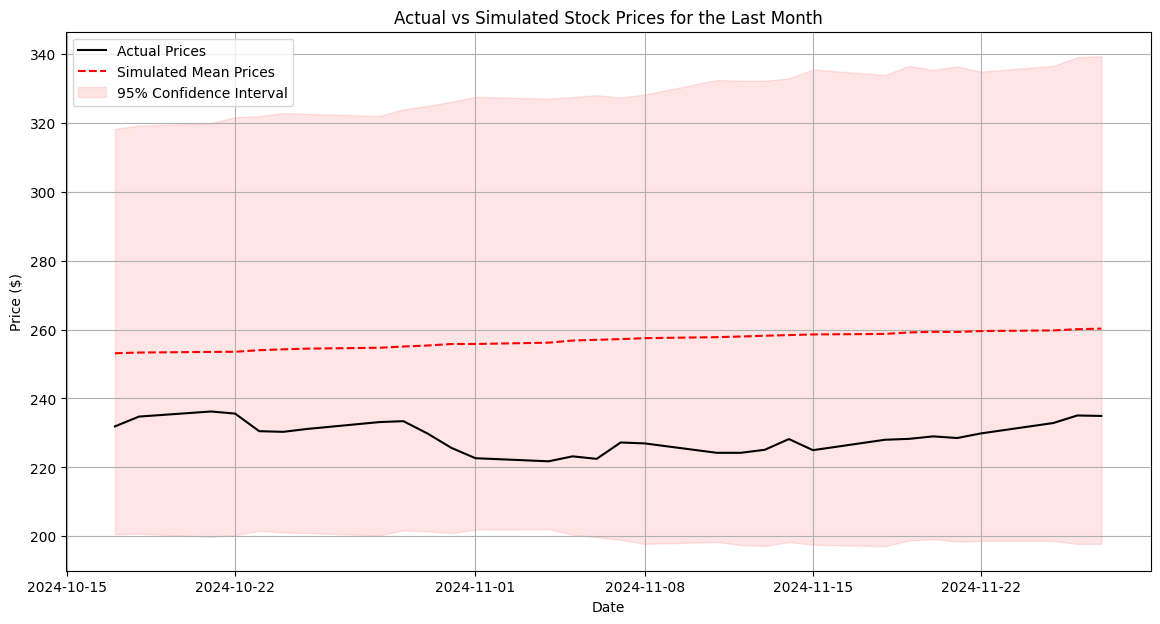

Mean Absolute Error (MAE) between actual and simulated mean prices: $27.81


In [23]:
# Extract actual prices for the last month
actual_prices = stock_analysis.df['Close'].iloc[-30:]

# Calculate the mean of the simulated prices for the last 30 days
simulated_prices_mean = np.mean(simulations[:, -30:], axis=0)

# Plot the actual prices and the simulated mean prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices.index, actual_prices.values, label='Actual Prices', color='black')
plt.plot(actual_prices.index, simulated_prices_mean, label='Simulated Mean Prices', color='red', linestyle='--')
plt.fill_between(actual_prices.index, 
                 np.percentile(simulations[:, -30:], 2.5, axis=0), 
                 np.percentile(simulations[:, -30:], 97.5, axis=0), 
                 color='red', alpha=0.1, label='95% Confidence Interval')
plt.title('Actual vs Simulated Stock Prices for the Last Month')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the Mean Absolute Error (MAE) between actual and simulated mean prices
mae = np.mean(np.abs(actual_prices.values - simulated_prices_mean))
print(f"Mean Absolute Error (MAE) between actual and simulated mean prices: ${mae:.2f}")


### Analysis of the Markov Chain Model

#### Reliability
- **Transition Matrix**: The transition matrix provides a probabilistic framework for understanding how stock prices move between different states. The reliability of the model depends on the accuracy of these probabilities, which are derived from historical data.
- **Stationary Distribution**: The stationary distribution indicates the long-term behavior of the stock price states. It helps in understanding the most likely states the stock will be in over a long period.
- **Backtesting Results**: The backtesting results show how well the model's predictions align with actual historical prices. The Mean Absolute Error (MAE) between actual and simulated mean prices provides a quantitative measure of the model's prediction accuracy.

#### Practical Insights
- **Probabilistic Forecasting**: The Markov chain model provides a probabilistic forecast of future stock prices, which can be useful for risk management and decision-making. Investors can use these probabilities to assess the likelihood of different price movements.
- **Confidence Intervals**: The 95% confidence interval gives an indication of the range within which the stock price is likely to fall. This can help investors understand the potential risk and volatility associated with the stock.
- **State Analysis**: By analyzing the states (e.g., Very Bearish, Bearish, Neutral, Bullish, Very Bullish), investors can gain insights into the market sentiment and make informed decisions based on the current state and its transition probabilities.
- **Simulation of Price Paths**: The ability to simulate multiple price paths allows investors to explore different scenarios and their potential outcomes. This can be particularly useful for stress testing and scenario analysis.

#### Limitations
- **Historical Dependence**: The model relies heavily on historical data to estimate transition probabilities. If the future market conditions differ significantly from the past, the model's predictions may not be accurate.
- **Simplified Assumptions**: The Markov chain model assumes that future states depend only on the current state and not on the sequence of past states. This simplification may not capture all the complexities of stock price movements.
- **Parameter Sensitivity**: The model's performance can be sensitive to the choice of the number of states and the method used to assign states. Different choices can lead to different transition matrices and stationary distributions.

